# iMet Collection 2019 - FGVC6
**Simple baseline for iMet Collection 2019 competition using fastai v1**

In [1]:
import fastai
from fastai.vision import *
fastai.__version__

'1.0.51'

# Setup

In [2]:
BATCH  = 126
SIZE   = 250
path = Path('../input/imet-2019-fgvc6/') # iMet data path

In [3]:
!ls ../input/resnet50/

resnet50.pth


In [4]:
# Making pretrained weights work without needing to find the default filename
from torch.utils import model_zoo
Path('models').mkdir(exist_ok=True)
!cp '../input/resnet50/resnet50.pth' 'models/'
def load_url(*args, **kwargs):
    model_dir = Path('models')
    filename  = 'resnet50.pth'
    if not (model_dir/filename).is_file(): raise FileNotFoundError
    return torch.load(model_dir/filename)
model_zoo.load_url = load_url

# Data

In [5]:
# Load train dataframe
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


In [6]:
# Load labels dataframe
labels_df = pd.read_csv(path/'labels.csv')
labels_df.head()

,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [7]:
# Load sample submission
test_df = pd.read_csv(path/'sample_submission.csv')
test_df.head()

,id,attribute_ids
0,10023b2cc4ed5f68,0 1 2
1,100fbe75ed8fd887,0 1 2
2,101b627524a04f19,0 1 2
3,10234480c41284c6,0 1 2
4,1023b0e2636dcea8,0 1 2


# Create data object using datablock API

In [8]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=0.10, max_zoom=1.5, max_warp=0.2, max_lighting=0.2,
                     xtra_tfms=[(symmetric_warp(magnitude=(-0,0), p=0)),])

In [9]:
train, test = [ImageList.from_df(df, path=path, cols='id', folder=folder, suffix='.png') 
               for df, folder in zip([train_df, test_df], ['train', 'test'])]
data = (train.split_by_rand_pct(0.1, seed=42)
        .label_from_df(cols='attribute_ids', label_delim=' ')
        .add_test(test)
        .transform(tfms, size=SIZE, resize_method=ResizeMethod.PAD, padding_mode='border',)
        .databunch(path=Path('.'), bs=BATCH).normalize(imagenet_stats))

In [10]:
data

ImageDataBunch;

Train: LabelList (98314 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: MultiCategoryList
147;616;813,51;616;734;813,776,51;671;698;813;1092,13;404;492;903;1093
Path: ../input/imet-2019-fgvc6;

Valid: LabelList (10923 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: MultiCategoryList
872,147;542;733;813;1092,51;393;584;671;746;784;954,13;813;896,498;637;704
Path: ../input/imet-2019-fgvc6;

Test: LabelList (7443 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: EmptyLabelList
,,,,
Path: ../input/imet-2019-fgvc6

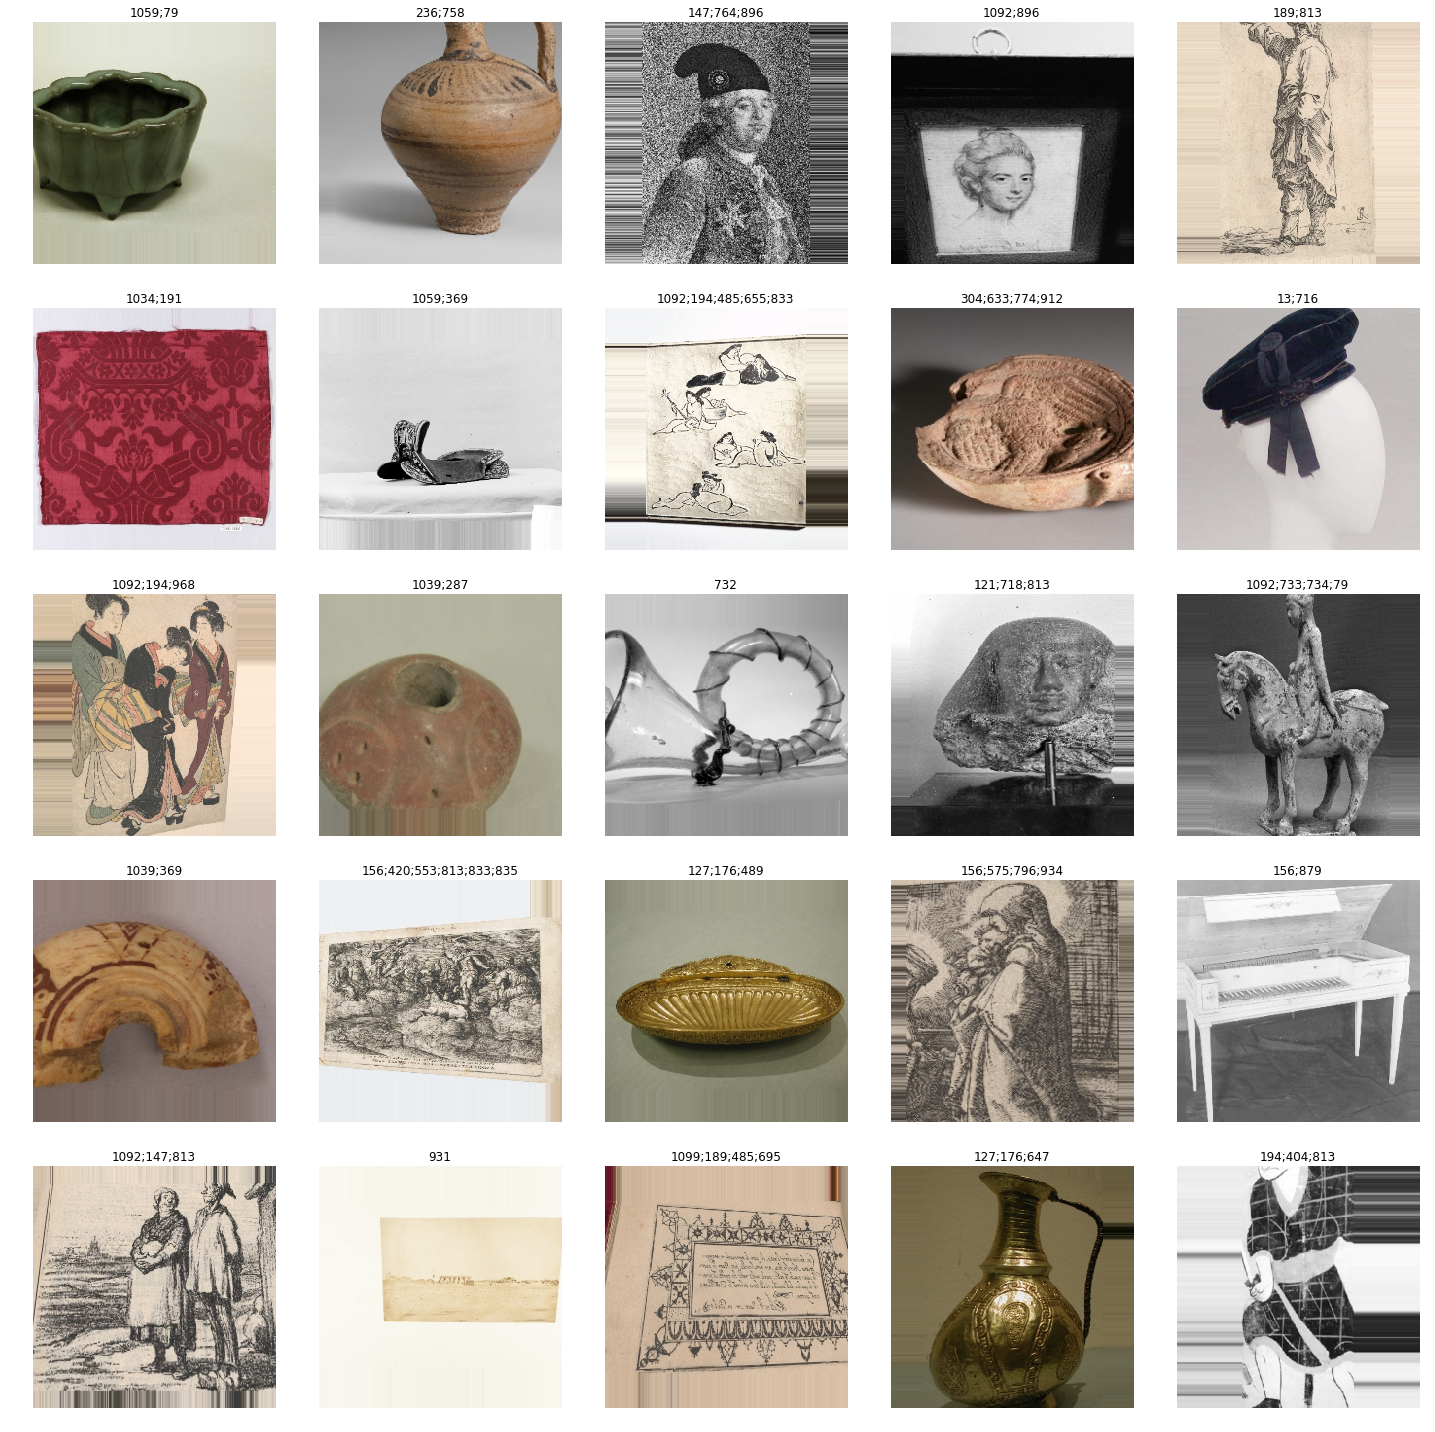

In [11]:
data.show_batch()

# Create learner with pretrenet model and FocalLoss
For problems with high class imbalance Focal Loss is usually a better choice than the usual Cross Entropy Loss.

In [12]:
# Source: https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/78109
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        return loss.mean()

In [13]:
learn = cnn_learner(data, base_arch=models.resnet50, loss_func=FocalLoss(), metrics=fbeta)

# Train the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


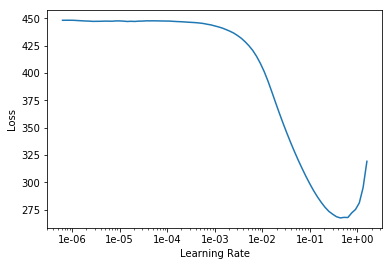

In [14]:
# Find a good learning rate
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.unfreeze()
learn.fit_one_cycle(22, slice(1e-5,1e-2))
learn.freeze()
learn.save('stage-1', return_path=True)

epoch,train_loss,valid_loss,fbeta,time
0,4.867121,4.048592,0.308352,21:48
1,3.760420,3.382531,0.394984,21:33
2,3.334453,3.134900,0.417740,21:22
3,3.236837,3.116616,0.448418,21:18
4,3.145784,5.704937,0.460729,21:15


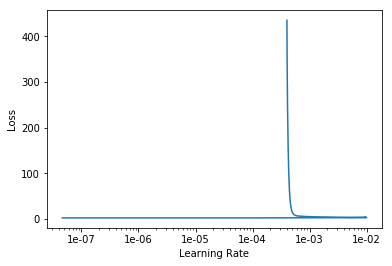

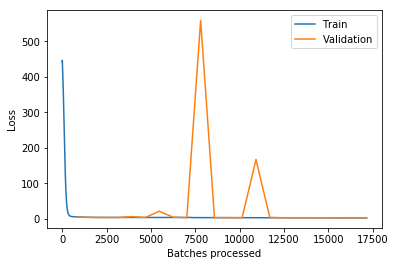

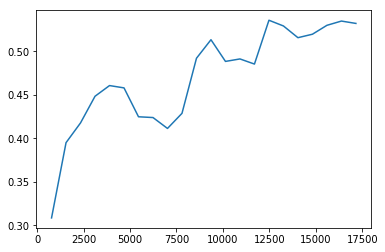

In [16]:
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [17]:
learn.export()

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Get predictions

In [18]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in progress_bar(thrs):
        score.append(fbeta(valid_preds[0],valid_preds[1], thresh=thr))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr

i2c = np.array([[i, c] for c, i in learn.data.train_ds.y.c2i.items()]).astype(int) # indices to class number correspondence

def join_preds(preds, thr):
    return [' '.join(i2c[np.where(t==1)[0],1].astype(str)) for t in (preds[0].sigmoid()>thr).long()]

thr=0.290 F2=0.591


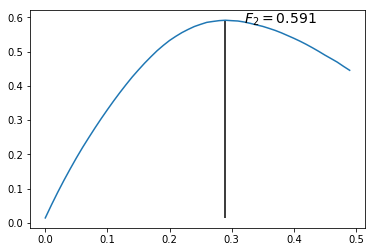

In [19]:
# Validation predictions
valid_preds = learn.get_preds(DatasetType.Valid)
best_thr = find_best_fixed_threshold(*valid_preds)

In [20]:
# Test predictions
#test_preds = learn.get_preds(DatasetType.Test)
#test_df.attribute_ids = join_preds(test_preds, best_thr)
#test_df.head()

In [21]:
#test_df.to_csv('submission.csv', index=False)

## TTA

In [22]:
# Validation predictions with TTA
#valid_preds = learn.TTA(ds_type=DatasetType.Valid)
#best_thr = find_best_fixed_threshold(*valid_preds)

In [23]:
# Test predictions with TTA
test_preds = learn.TTA(ds_type=DatasetType.Test)
test_df.attribute_ids = join_preds(test_preds, best_thr)
test_df.head()

,id,attribute_ids
0,10023b2cc4ed5f68,1039 1059 1084 195 766
1,100fbe75ed8fd887,1039 231 872 93
2,101b627524a04f19,420 784 79
3,10234480c41284c6,1046 147 480 483 51 725 738 776 813 830 923
4,1023b0e2636dcea8,1046 1092 147 322 477 584 671 738 776 813 954


In [24]:
test_df.to_csv('submission.csv', index=False) 